In [6]:
from config import Config
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas
import os
import m3u8
from datetime import datetime
from datetime import timedelta
import re
import copy

channel="nickjr_rom"
txdate="2019-10-06"


In [7]:
def get_commercial_log(channel,txdate):
    breaks=[]
    local_feed=[lf for lf in Config.LOCALIZED_FEEDS if lf["dir"]==channel][0]
    xls_filename=os.path.join(Config.STREAMS_ROOT,local_feed["dir"],"commercials","playlists",
                          txdate,txdate+"_"+local_feed["log"]+".xls")
    df=pandas.read_excel(xls_filename)
    for b in df["Break Number"].unique():
        com_break={}
        com_break["id"]=b
        com_break["starttime"]=df[df["Break Number"] == b].iloc[0]["Start Time"][0:-3]
        com_break["duration"]='{:02d}:{:02d}'.format(int(df[df["Break Number"] == b]["Duartion WORK"].sum()/60),
                                             df[df["Break Number"] == b]["Duartion WORK"].sum()%60)
        if os.path.isfile(os.path.join(Config.STREAMS_ROOT,local_feed["dir"],"commercials","playlists",
                                           txdate,'brk_{:02d}'.format(b),"playlist.m3u8")):
            com_break["manifest"]=os.path.join(Config.BASE_URI,local_feed["dir"],"commercials","playlists",
                                           txdate,'brk_{:02d}'.format(b),"playlist.m3u8")
            com_break["segments"]=[]
            for segment in m3u8.load(com_break["manifest"]).segments:
                com_break["segments"].append(segment.uri)
        breaks.append(com_break)
    return breaks

In [10]:
def ts_to_datetime(ts):
    (hour,min,sec)=ts.split(':')
    return datetime(1900,1,int(int(hour)/24)+1,int(hour)%24,int(min),int(sec.split('.')[0]),int(sec.split('.')[1]))

def ts_to_timedelta(ts):
    (hour,min,sec)=ts.split(':')
    return timedelta(hours=int(hour),minutes=int(min),seconds=int(sec.split('.')[0]),microseconds=int(sec.split('.')[1]))

def get_segments_played(channel,txdate):
    downloads=[]
    parse_packets=[]
    regex_download=r"([^\s]*)(.*)(http:.*)"
    regex_timestamp=r"([^\s]*).*Pushing out pending packets at: ([^\s]*) ([^\s]*).*Timestamp:([^\s]*) DUR:([^\s]*) SIZE:([^\s]*)"
    hls2rtp_logs="/home/lajos/projects/ottstreamer/hls2rtp/logs"
    local_feed=[lf for lf in Config.LOCALIZED_FEEDS if lf["dir"]==channel][0]
    txdate_datetime=datetime.strptime(txdate,'%Y-%m-%d')
    if txdate_datetime.date()==datetime.now().date():
        hls2rtp_log=os.path.join(hls2rtp_logs,"hls2rtp_"+local_feed["dir"]+".log")
    else:
        hls2rtp_log=os.path.join(hls2rtp_logs,"hls2rtp_"+local_feed["dir"]+".log-"+txdate_datetime.strftime('%Y%m%d'))

    base_wallclock=datetime(1900, 1, 1, 0, 0)
    base_timestamp=datetime(1900, 1, 1, 0, 0)
    prev_end_timestamp=datetime(1900, 1, 1, 0, 0)
    download={}
    with open(hls2rtp_log) as file:
        for ln,line in enumerate(file):
            if "Pushing out pending packets at:" in line:
                parse_packet={}
                if line.find("percent. ") > 0:
                    line=line[line.find("percent. ")+9:]
                match=re.search(regex_timestamp,line)
                base_timestamp=ts_to_datetime(match.group(1)[0:-3])
                base_wallclock=datetime.strptime(match.group(2) +" " + match.group(3),"%Y-%m-%d %H:%M:%S.%f")
                parse_packet["linenumber"]=ln
                parse_packet["wallclock"]=datetime.strptime(match.group(2) +" " + match.group(3),"%Y-%m-%d %H:%M:%S.%f")
                parse_packet["timestamp"]=ts_to_datetime(match.group(1)[0:-3])
                parse_packet["PCR"]=ts_to_datetime(match.group(4)[0:-3])
                parse_packet["Duration"]=ts_to_timedelta(match.group(5)[0:-3])
                parse_packet["Size"]=int(match.group(6))
                parse_packets.append(parse_packet)

            elif "Downloading fragment uri" in line:
                match=re.search(regex_download,line)
                download={}
                download["gap"]=ts_to_datetime(match.group(1)[0:-3])-prev_end_timestamp
                download["start_linenumber"]=ln
                download["start_timestamp"]=ts_to_datetime(match.group(1)[0:-3])
                download["start_wallclock"]=base_wallclock+(download["start_timestamp"]-base_timestamp)
                download["url"]=match.group(3).split(' ')[0][0:-1]
            elif "fragment download finished" in line:
                match=re.search(regex_download,line)
                download["end_linenumber"]=ln
                download["end_timestamp"]=ts_to_datetime(match.group(1)[0:-3])
                prev_end_timestamp=download["end_timestamp"]
                download["end_wallclock"]=base_wallclock+(download["end_timestamp"]-base_timestamp)
                download["result"]=match.group(3).split(' ')[1]
                download["result2"]=match.group(3).split(' ')[2]
                if "start_wallclock" in download:
                    downloads.append(download)
    return downloads,parse_packets

In [11]:
cl=get_commercial_log(channel,txdate)
ar,tp=get_segments_played(channel,txdate)

In [12]:
for brk in cl:
    try:
        com_fragments=[]
        for segment in brk["segments"]:
            com_fragments.append([a["url"] for a in ar].index(segment))
        print('Break {} scheduled for {} is played at {} with duration:{}.'.
              format(brk["id"],brk["starttime"],ar[com_fragments[0]]["start_wallclock"].strftime('%H:%M:%S'),
                    (ar[com_fragments[-1]]["end_wallclock"]-ar[com_fragments[0]]["start_wallclock"])))
    except:
        print('Break {} scheduled for {} is not played.'.format(brk["id"],brk["starttime"]))

Break 1 scheduled for 06:21:00 is not played.
Break 2 scheduled for 06:50:00 is not played.
Break 3 scheduled for 07:18:00 is not played.
Break 4 scheduled for 07:47:00 is not played.
Break 5 scheduled for 08:27:00 is not played.
Break 6 scheduled for 09:22:00 is not played.
Break 7 scheduled for 09:50:00 is not played.
Break 8 scheduled for 10:18:00 is not played.
Break 9 scheduled for 10:55:00 is not played.
Break 10 scheduled for 11:21:00 is not played.
Break 11 scheduled for 11:49:00 is not played.
Break 12 scheduled for 12:15:00 is not played.
Break 13 scheduled for 12:44:00 is not played.
Break 14 scheduled for 13:17:00 is not played.
Break 15 scheduled for 13:45:00 is not played.
Break 16 scheduled for 14:14:00 is not played.
Break 17 scheduled for 14:32:00 is not played.
Break 18 scheduled for 15:22:00 is not played.
Break 19 scheduled for 15:50:00 is not played.
Break 20 scheduled for 16:17:00 is not played.
Break 21 scheduled for 16:46:00 is not played.
Break 22 scheduled for

/ddrive/ottstreamer/webapp/venv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


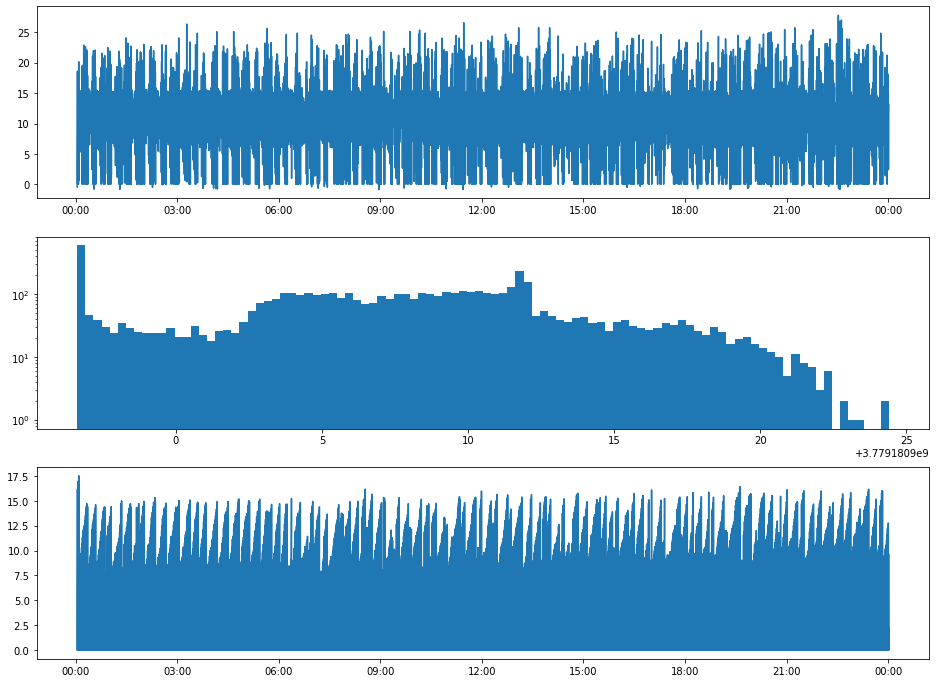

In [13]:
start=1
stop=len(ar)
fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(16, 12))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.plot([a["start_wallclock"] for a in ar[start:stop]],
            [(a["end_wallclock"]-a["start_wallclock"]).total_seconds() for a in ar[start:stop]]);
ax2.hist( [(a["end_wallclock"]-a["start_timestamp"]).total_seconds() for a in ar[start:stop]],log=True,bins=100);
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax3.plot([a["start_wallclock"] for a in ar[start:stop]],
            [a["gap"].total_seconds() for a in ar[start:stop]]);

In [14]:
[a for a in ar if (a["end_wallclock"]-a["start_wallclock"])>timedelta(seconds=25)]

[{'gap': datetime.timedelta(days=1, seconds=41617, microseconds=32219),
  'start_linenumber': 11,
  'start_timestamp': datetime.datetime(1900, 1, 2, 11, 33, 37, 32219),
  'start_wallclock': datetime.datetime(1900, 1, 2, 11, 33, 37, 32219),
  'url': 'http://129.228.120.86/streams/nickjr_pol/segment_08463.ts',
  'end_linenumber': 163,
  'end_timestamp': datetime.datetime(1900, 1, 2, 11, 33, 52, 476683),
  'end_wallclock': datetime.datetime(2019, 10, 6, 0, 2, 9, 566914),
  'result': '0',
  'result2': 'ok'},
 {'gap': datetime.timedelta(seconds=12, microseconds=797757),
  'start_linenumber': 140439,
  'start_timestamp': datetime.datetime(1900, 1, 2, 14, 48, 10, 349804),
  'start_wallclock': datetime.datetime(2019, 10, 6, 3, 16, 26, 931309),
  'url': 'http://129.228.120.86/streams/nickjr_pol/segment_09228.ts',
  'end_linenumber': 140594,
  'end_timestamp': datetime.datetime(1900, 1, 2, 14, 48, 36, 451114),
  'end_wallclock': datetime.datetime(2019, 10, 6, 3, 16, 53, 293988),
  'result': '0',

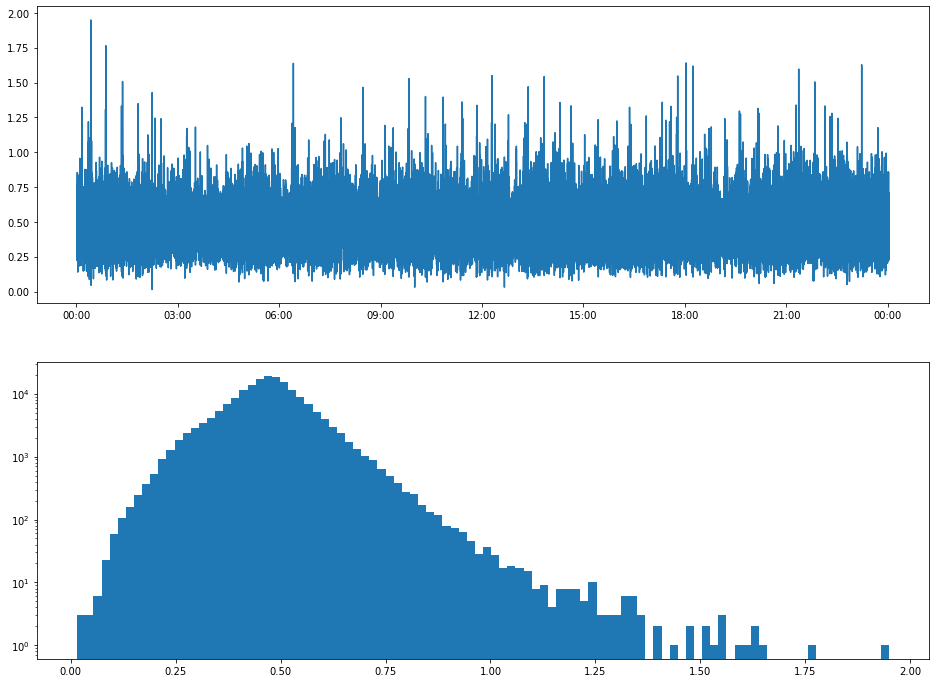

In [15]:
#tsparse packet durations...
fig,(ax1,ax2)=plt.subplots(2,1,figsize=(16,12))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.plot([t["wallclock"]for t in tp],[t["Duration"].total_seconds() for t in tp])
ax2.hist( [t["Duration"].total_seconds() for t in tp],log=True,bins=100);

In [16]:
[t for t in tp if t["Duration"].total_seconds()==0]



[]

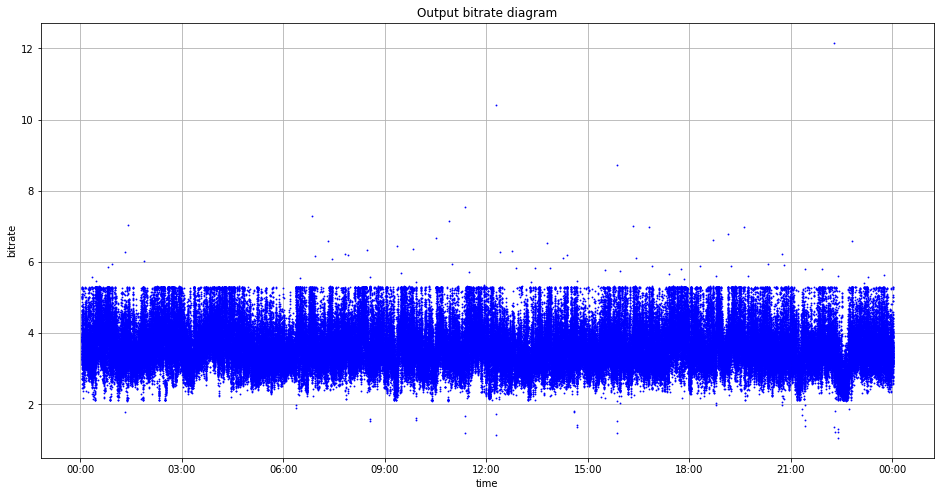

In [17]:
#output bitrate..
fig,ax1=plt.subplots(figsize=(16,8))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.plot([t["wallclock"]for t in tp if t["Duration"].total_seconds()>0],
         [t["Size"]*8/1000000/t["Duration"].total_seconds() for t in tp if t["Duration"].total_seconds()>0],"bp",markersize=1);
plt.xlabel("time");
plt.ylabel("bitrate");
plt.title("Output bitrate diagram");
plt.grid(True);


In [18]:
#Packets with duration > 2sec.  Most likely freezed frame..... 
[t for t in tp if t["Duration"]>timedelta(seconds=2)]

[]

In [19]:
[r for r in ar if (r["end_wallclock"]-r["start_wallclock"])>timedelta(seconds=25)]

[{'gap': datetime.timedelta(days=1, seconds=41617, microseconds=32219),
  'start_linenumber': 11,
  'start_timestamp': datetime.datetime(1900, 1, 2, 11, 33, 37, 32219),
  'start_wallclock': datetime.datetime(1900, 1, 2, 11, 33, 37, 32219),
  'url': 'http://129.228.120.86/streams/nickjr_pol/segment_08463.ts',
  'end_linenumber': 163,
  'end_timestamp': datetime.datetime(1900, 1, 2, 11, 33, 52, 476683),
  'end_wallclock': datetime.datetime(2019, 10, 6, 0, 2, 9, 566914),
  'result': '0',
  'result2': 'ok'},
 {'gap': datetime.timedelta(seconds=12, microseconds=797757),
  'start_linenumber': 140439,
  'start_timestamp': datetime.datetime(1900, 1, 2, 14, 48, 10, 349804),
  'start_wallclock': datetime.datetime(2019, 10, 6, 3, 16, 26, 931309),
  'url': 'http://129.228.120.86/streams/nickjr_pol/segment_09228.ts',
  'end_linenumber': 140594,
  'end_timestamp': datetime.datetime(1900, 1, 2, 14, 48, 36, 451114),
  'end_wallclock': datetime.datetime(2019, 10, 6, 3, 16, 53, 293988),
  'result': '0',

In [20]:
[t["wallclock"]for t in tp]

[datetime.datetime(2019, 10, 6, 0, 1, 53, 615265),
 datetime.datetime(2019, 10, 6, 0, 2, 5, 332783),
 datetime.datetime(2019, 10, 6, 0, 2, 5, 783004),
 datetime.datetime(2019, 10, 6, 0, 2, 6, 287208),
 datetime.datetime(2019, 10, 6, 0, 2, 6, 837575),
 datetime.datetime(2019, 10, 6, 0, 2, 7, 227976),
 datetime.datetime(2019, 10, 6, 0, 2, 7, 710918),
 datetime.datetime(2019, 10, 6, 0, 2, 8, 215935),
 datetime.datetime(2019, 10, 6, 0, 2, 8, 715051),
 datetime.datetime(2019, 10, 6, 0, 2, 9, 185920),
 datetime.datetime(2019, 10, 6, 0, 2, 9, 213460),
 datetime.datetime(2019, 10, 6, 0, 2, 9, 233680),
 datetime.datetime(2019, 10, 6, 0, 2, 9, 271680),
 datetime.datetime(2019, 10, 6, 0, 2, 9, 298300),
 datetime.datetime(2019, 10, 6, 0, 2, 9, 316710),
 datetime.datetime(2019, 10, 6, 0, 2, 9, 328150),
 datetime.datetime(2019, 10, 6, 0, 2, 9, 341320),
 datetime.datetime(2019, 10, 6, 0, 2, 9, 354400),
 datetime.datetime(2019, 10, 6, 0, 2, 9, 369800),
 datetime.datetime(2019, 10, 6, 0, 2, 9, 384040),

In [24]:
ar[-3:]

[{'gap': datetime.timedelta(microseconds=419),
  'start_linenumber': 617192,
  'start_timestamp': datetime.datetime(1900, 1, 1, 22, 52, 42, 758054),
  'start_wallclock': datetime.datetime(2019, 9, 30, 11, 35, 51, 167979),
  'url': 'http://129.228.120.86/streams/nickjr_pol/segment_05630.ts',
  'end_linenumber': 617352,
  'end_timestamp': datetime.datetime(1900, 1, 1, 22, 52, 58, 61540),
  'end_wallclock': datetime.datetime(2019, 9, 30, 11, 36, 6, 471472),
  'result': '0',
  'result2': 'ok'},
 {'gap': datetime.timedelta(microseconds=671),
  'start_linenumber': 617358,
  'start_timestamp': datetime.datetime(1900, 1, 1, 22, 52, 58, 62211),
  'start_wallclock': datetime.datetime(2019, 9, 30, 11, 36, 6, 472143),
  'url': 'http://129.228.120.86/streams/nickjr_pol/segment_05631.ts',
  'end_linenumber': 617605,
  'end_timestamp': datetime.datetime(1900, 1, 1, 22, 53, 13, 452586),
  'end_wallclock': datetime.datetime(2019, 9, 30, 11, 36, 21, 862509),
  'result': '0',
  'result2': 'ok'},
 {'gap':